# Introduction to Joining Data in GeoPandas

## Loading Packages and Data

GeoPandas and pandas are typically imported using the aliases `gpd` and `pd`. GeoPandas exposes many (but not all) pandas methods, so import pandas as well. Import pyplot using the alias `plt`.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Begin by reading in the US counties shapefile. The link is to counties generalized for 20,000,000:1 (continental) scale mapping. For geometries are from 2010, and are appropriate for use with the 2010 Decennial Census.

In [22]:
geo = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2010/gz_2010_us_050_00_20m.zip")

After downloading, plot the GeoDataFrame using default settings. `plt.show` is not necessary if you are running this code in Spyder. In the notebook, it prevents display of the object identifier for the matplotlib object created by the call to `geo.plot`.

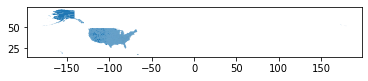

In [23]:
geo.plot()
plt.show()

A Python object can be "pickled", which means that a byte stream of the object is written to disk for later loading. Make sure that the file **ga_county.pickle** is in the same directory as this notebook. This pickle contains a pandas data frame with Georgia county data from subject table P5 - Hispanic or Latino Origin By Race. Load it and assign to the variable `ga_county`.

In [12]:
ga_county = pd.read_pickle("ga_county.pickle")
ga_county.head()

,name,total,nonhispanic,white,black,aian,asian,pacific,other,multiracial,hispanic,hispanic_white,hispanic_black,hispanic_aian,hispanic_asian,hispanic_pacific,hispanic_other,hispanic_multiracial,state,county
0,"Banks County, Georgia",18395,17354,16526,416,36,165,0,9,202,1041,351,11,21,0,3,597,58,13,011
1,"Barrow County, Georgia",69367,63330,51736,7769,130,2359,28,141,1167,6037,2929,120,56,23,8,2460,441,13,013
2,"Ben Hill County, Georgia",17634,16608,10164,6087,47,120,2,15,173,1026,282,17,9,6,0,650,62,13,017
3,"Camden County, Georgia",50513,47923,35977,9621,230,706,70,72,1247,2590,1580,178,29,18,6,495,284,13,039
4,"Bleckley County, Georgia",13063,12762,9000,3533,7,109,3,8,102,301,151,31,6,1,0,86,26,13,023


## Inner Joins

We would like to join the data from this pandas DataFrame to the GeoDataFrame `geo` for mapping and spatial analysis. To do so, we first have to identify the join key(s), the column(s) that contain matching identifiers. Looking at the data in `ga_county`, you might realize that most of the columns contain population count data. The counties can be identified by the `name` column, but also by the codes in the `state` and `county` columns. Let's look at the data in `geo` to see if there are any potential matching columns.

In [13]:
geo.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.496774 32.344437, -86.7178969999..."
1,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.577799 33.765316, -86.7591439999..."
2,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413099999999 32.870525, -85.12..."
3,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734399999999 33.020566, -86.51..."
4,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.139988 34.581703, -88.139246 34...."


The `name` column in `ga_county` had names of the form "<Name> County, <State>". Note that `geo` also has a `NAME` column, but the column contains a bare county name. There are no consistently used data standards for names, and in general, names are often a poor choice to use as a join field. People's names may include a middle initial, a nickname, an honorific, etc. Place names are similarly inconsistent.

`geo` does have a `STATE` and `COUNTY` column. These are two- and three-digit columns which look like they could be used to match the `state` and `county` columns in `ga_county`. In fact, these are Federal Information Processing Standards (FIPS) codes, which are used to uniquely identify geographic entities in the United States.

Two methods are used to perform joins in pandas. The `merge` method is the core method, and `join` is a convenience method that applies certain defaults. `join` is most useful when the keys are the data frames' indexes. We will begin with `merge`.

The two DataFrames being joined are referred to as "left" and "right". The left data frame is the one that is literally *on the left* of the line of code, that is, the one that is mentioned first. When calling `merge`, the join key can be specified in several ways. When the column names in the two data frames are different, keys must be specified using the `left_on` and `right_on` parameters. Because we are using a multicolumn join, the argument is passed as a list of column names. For a single-column join, the list brackets are usually omitted (but are harmless if included).

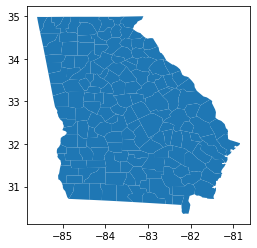

In [24]:
geo1 = pd.merge(left = geo, right = ga_county, left_on = ["STATE", "COUNTY"], right_on = ["state", "county"])
geo1.plot()
plt.show()

When we plotted `geo`, we saw all counties in the United States. Notice that now `geo1` only includes counties in Georgia. `merge` includes a `how` parameter, used to specify how to perform the join. The default is an **inner join** (`how = "inner"`), which retains only rows where the key is found in both the left and right DataFrames. Since `ga_county` only includes counties in Georgia, all of the rows in `geo` for counties outside of Georgia were dropped.

When the join columns have the same names, the keys can be specified more simply using the `on` parameter. (For those familiar with SQL, this is equivalent to the `USING` keyword.) To demonstrate, first rename the columns in `geo` (deleting some columns we are not interested in). Then, specify the matching field names *once*, since they are the same in both DataFrames. Note also that the `left` and `right` parameters are the first positional parameters, so the parameter names are usually omitted.

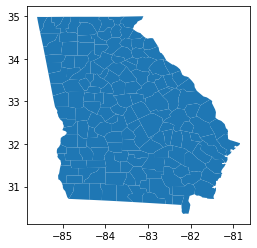

In [25]:
geo.drop(columns = ["GEO_ID", "NAME", "LSAD", "CENSUSAREA"], inplace = True)
geo.rename(columns = {"STATE": "state", "COUNTY": "county"}, inplace = True)

geo1 = pd.merge(geo, ga_county, on = ["state", "county"])
geo1.plot()
plt.show()

`merge` can also be called as a method of the left DataFrame, in which case the first parameter is the name of the right DataFrame. The following two lines of code produce the same result. Which one you use is a matter of taste.

In [ ]:
geo1 = pd.merge(geo, ga_county, on = ["state", "county"])
geo1 = geo.merge(ga_county, on = ["state", "county"])

When joining additional attribute data (that is, nonspatial data) to a spatial table, *the GeoDataFrame **must** be on the left*. Note the type of `geo1`:

In [26]:
type(geo1)

geopandas.geodataframe.GeoDataFrame

Now reverse left and right, and note the type of object produced.

In [28]:
geo2 = pd.merge(ga_county, geo, on = ["state", "county"])
type(geo2)

pandas.core.frame.DataFrame

The DataFrame still has a column named `geometry`, which contains shapely objects, but it is not longer understood to be a GeoDataFrame, and cannot be used for mapping or spatial analysis. If this happens, it is possible to turn a DataFrame into a GeoDataFrame by assigning a CRS (Coordinate Reference System) and specifying which column is the geometry column. In the code below, the somewhat unhelpful `geometry = "geometry"` means "the geometry column is the column *named* geometry". Census data is provided in lat-long coordinates using North American Datum 1983. The CRS parameters can be shortcut using [EPSG 4269](http://epsg.io/4269).

In [31]:
geo_recovery = gpd.GeoDataFrame(geo2, crs = {"init": "epsg:4269"}, geometry = "geometry")
type(geo_recovery)

geopandas.geodataframe.GeoDataFrame

Using the `gpd.GeoDataFrame` constructor can be very useful when given a table with lat-long (or other X-Y) coordinates. See [Creating a GeoDataFrame from a DataFrame with coordinates](http://geopandas.org/gallery/create_geopandas_from_pandas.html#creating-a-geodataframe-from-a-dataframe-with-coordinates). However, as we are discussing joins, do not use this to recover from a "backwards" join. Just remember to use the GeoDataFrame as the left DataFrame when joining.

## Outer Joins

Previously we did an **inner join**, which only retains rows that match between the two tables. You will sometimes want to do an **outer join** which retains rows from the left or right table, or both, even if there they key does not have a match in the other table. Since the left and right ordering is arbitrary, a **left join** can be rewritten as a **right join**, and vice versa. In practice, analysts will usually prefer to use left joins exclusively. Spatial analysts in particular will almost always use left joins, because they are almost always adding additional "attribute data" (nonpspatial columns) to a spatial data set, and as we saw previously, for the pandas `merge` to preserve the geospatial data the GeoDataFrame must be the on the left.

The left join is accomplished using the `how` parameter. The options are `"left"`, `"right"`, and `"outer"`. These are *all* outer joins, but `"outer"` in this context means a **full outer join**, which retains all rows from *both* the left and right tables, even for keys that have no match in the other table.

An example of a left join using the data we currently have loaded is as follows:

In [42]:
geo_left_join = pd.merge(geo, ga_county, on = ["state", "county"], how = "left")
len(geo_left_join) == len(geo)

True

Note that the length of the resulting data frame `geo_left_join` is the same as the length of the left data frame `geo`. Previously we created `geo1` using an inner join, and the length does *not* equal the length of `geo`:

In [43]:
len(geo1) == len(geo)

False

## Joining on Indexes

If your key is in your DataFrame index

In [44]:
geo_idx = geo.set_index(["state", "county"])
geo_idx.head()

geometry
state county                                                   
01    001     POLYGON ((-86.496774 32.344437, -86.7178969999...
      009     POLYGON ((-86.577799 33.765316, -86.7591439999...
      017     POLYGON ((-85.18413099999999 32.870525, -85.12...
      021     POLYGON ((-86.51734399999999 33.020566, -86.51...
      033     POLYGON ((-88.139988 34.581703, -88.139246 34....

In [46]:
ga_county_idx = ga_county.set_index(["state", "county"])
ga_county_idx.head()

name  total  nonhispanic  white  black  \
state county                                                               
13    011        Banks County, Georgia  18395        17354  16526    416   
      013       Barrow County, Georgia  69367        63330  51736   7769   
      017     Ben Hill County, Georgia  17634        16608  10164   6087   
      039       Camden County, Georgia  50513        47923  35977   9621   
      023     Bleckley County, Georgia  13063        12762   9000   3533   

              aian  asian  pacific  other  multiracial  hispanic  \
state county                                                       
13    011       36    165        0      9          202      1041   
      013      130   2359       28    141         1167      6037   
      017       47    120        2     15          173      1026   
      039      230    706       70     72         1247      2590   
      023        7    109        3      8          102       301   

              hispanic_white  hispanic_black  hispanic_aian  hispanic_asian  \
state county                                                                  
13    011                351              11             21               0   
      013               2929             120             56              23   
      017                282              17              9               6   
      039               1580             178             29              18   
      023                151              31              6               1   

              hispanic_pacific  hispanic_other  hispanic_multiracial  
state county                                                          
13    011                    3             597                    58  
      013                    8            2460                   441  
      017                    0             650                    62  
      039                    6             495                   284  
      023                    0              86                    26

Once you 

In [48]:
geo3 = pd.merge(geo_idx, ga_county_idx, left_index = True, right_index = True)
len(geo3)

159

If you are joining by index, the `join` method can be a less verbose way to accomplish this. `join` is a wrapper for `merge` that by default joins on the DataFrames indexes. This behavior can be altered, but we won't explore all of the parameters here. Refer to the [`DataFrame.join`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) documentation for more information. Importantly, note that `join` defaults to a *left join*, whereas `merge` defaults to an *inner join*. An inner join can be specified with `how = "inner"`.

In [50]:
geo3 = geo_idx.join(ga_county_idx)
len(geo3)

3221

Between these options, I would say that joining on columns (using `merge`) is more SQL-like, and joining on indexes (using `join`) is more Pythonic. Which one you use is a matter of taste. If your shop can be disciplined about how indexes are defined, there might be advantages to using the `join` syntax. But since DataFrames always have a serial index if no other index is supplied, you do run the risk of creating unintended joins if you aren't paying attention. For example, you try to join county data, but unintentionally use a state GeoDataFrame that does not have the column with a county ID key column, `merge` will fail. If you use `join` but the DataFrames have the default serial indexes (that is, have not been set to use geographic identifiers in the indexes), the DataFrames will be joined row-by-row, and the result will be nonsense.

## Basic Choropleth Mapping

With the demographic data now joined to the shapefile, it is possible to create visualizations of the data. To begin, we project the geometries to an appropriate local CRS. A choropleth (color-shaded) map should not show raw counts, so we create a percent Hispanic column.

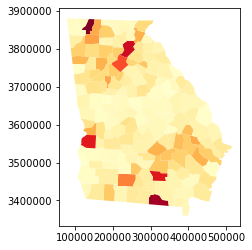

In [36]:
geo1 = geo1.to_crs(epsg = 26917)
geo1["pct_hispanic"] = 100 * geo1["hispanic"] / geo1["total"]
geo1.plot(column = "pct_hispanic", cmap = "YlOrRd")
plt.show()

## GIS Join Fields

SQL and Python can accommodate multicolumn joins, but desktop GIS such as QGIS and ArcGIS cannot. They can only join on a single column. Some Census data sources specify an appropriate single-column geographic identifier that can be used for joins.

Early Census files contained a `GEOID` field, which can be seen in the printout of `geo` above. (This column was subsequently dropped.) The ID has the form "0500000US01001". The first three digits represent the **summary level**, a three-digit code for the geographic level. "050" is the code for county-level data. The next four 0s have a specific meaning, but in the data we are using are always going to be 0 and can be ignored. This is followed by "US", then the concatenated FIPS identifiers for the geography. This five-digit identifier is state "01" (Alabama) and county "001" (Autauga). It is this identifier that is commonly used by Census analysts for joins, and in more recent geospatial data released by the Census Bureau, the `GEOID` filed now contains identifiers of this format. The old-style identifier is preserved as `AFFGEOID` (for "American Fact Finder GEOID").

In [59]:
geo2017 = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_county_20m.zip")
geo2017.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,075,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
1,25,025,00606939,0500000US25025,25025,Suffolk,06,150855462,160479920,"POLYGON ((-71.19115499999999 42.283059, -71.15..."
2,31,007,00835826,0500000US31007,31007,Banner,06,1932676697,397069,"POLYGON ((-104.052825235239 41.69795385306401,..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653705784,42187365,"POLYGON ((-78.497783 36.514477, -78.4572778962..."
4,48,421,01383996,0500000US48421,48421,Sherman,06,2390651189,428754,"POLYGON ((-102.162463 36.500326, -102.03233901..."


As the Census API calls will not return a single-column identifier, the GEOIDs across various heirarchies must be concatenated for use as a single-column join key.

In [62]:
ga_county_mhi = pd.read_pickle("ga_county_mhi.pickle")
ga_county_mhi.head()

,name,median_household_income,state,county
0,"Clay County, Georgia",23315,13,061
1,"Echols County, Georgia",34315,13,101
2,"Glynn County, Georgia",47546,13,127
3,"DeKalb County, Georgia",55876,13,089
4,"Haralson County, Georgia",43663,13,143


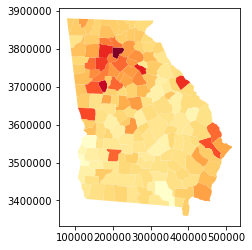

In [63]:
ga_county_mhi["GEOID"] = ga_county_mhi["state"] + ga_county_mhi["county"]
geo2017 = geo2017.to_crs(epsg = 26917)
geo2017 = pd.merge(geo2017, ga_county_mhi, on = "GEOID")
geo2017.plot(column = "median_household_income", cmap = "YlOrRd")
plt.show()

## Caveats

Some of you will be downloading Census data from [NHGIS.org](https://nhgis.org/). NHGIS makes it easy to select matching geospatial and attribute data, and provides a `GISJOIN` column that can be used as a single-column join between the resulting shapefile and CSV file. This is straightforward and is not demonstrated here.

The NHGIS `GISJOIN` field contains FIPS codes but follows a format unique to NHGIS, so *cannot* be used (without further manipulation) to join NHGIS-sourced shapefiles to Census-sourced attribute data, or Census-sourced shapefiles to NGHIS-sourced attribute data. If you want to combine data from mixed sources, you will have to use string manipulation to coerce the field from one format to the other.

You must pay attention to the **vintage** (data year) of Census products. Census geographies go through an overhaul every several years, but there are also small year-to-year changes, which include a combination of legal entity changes (e.g. a county's boundary shifting in relation to a neighboring county) as well as accuracy improvements in the data (which means the geometries will change, even though there is no "real world" change to the adminstrative boundary of the entity). Attibute data should always be joined to geospatial data of the same vintage. If you are working with ACS 2017 data, you should download TIGER/Line or Cartographic Boundary files for 2017. If you are working with 2010 Decennial Census data, you should download TIGER/Line or Cartographic Boundary files for 2010.

## Spatial Joins

So far, we have been doing what GIS analysts call an **attribute join**, which just means a join on nonspatial key fields. (It's still an attribute join if one of the input DataFrames is spatial.) A **spatial join** matches rows based on a *spatial relationship* between the two data frames. Since the join is based on a spatial relationship, both data frames must be GeoDataFrames.

A spatial join does not in any way alter the input geometries. That is, while you might be familiar with an intersection operation that creates a new geometry based on the overlapping region of two input geometries, a spatial join merely asks whether the two geometries intersect (that is, share any points in common, including boundary points). If it does, then the attributes (nonspatial columns) of the right GeoDataFrame are added to the left GeoDataFrame. The geometries of the left GeoDataFrame are not altered in any way.

So far, we have also been restricting ourselves to one-to-one joins. That is, each row had at most one matching row in the other table. One-to-many and many-to-many joins are also possible. For example, each state has multiple counties. If you have a county DataFrame and a state DataFrame, you might want to add information about each state to the county DataFrame. The data for each state would be repeated for every county in that state. While one-to-many and many-to-many joins are possible and even common with attribute data, they are especially likely with spatial joins, for example because point phenomena, such as UFO sightings, are likely to happen many times within geographic areas, such as states (and especially in New Mexico).

In the [VRDI Introduction to GIS](https://github.com/gerrymandr/vrdi-intro-gis) you used Boston polling places (point) and precincts (polygons) to analyze polling place access. We will do something similar using GeoPandas. Start by loading the polling place coordinates and constructing a GeoDataFrame. We assing [EPSG:4326](http://epsg.io/4326), the coordinate system used for GPS lat-long coordinates, and very commonly the correct one to use if you are given lat-long data with no further information.

In [20]:
polling = pd.read_csv("https://raw.githubusercontent.com/gerrymandr/vrdi-intro-gis/master/5.%20Point-Data/Polling_Locations_2017.csv")
geo_polling = gpd.GeoDataFrame(polling, crs = {"init": "epsg:4326"}, geometry = gpd.points_from_xy(polling.LONG, polling.LAT))
geo_polling.head()

,OBJECTID,NAME,ADDRESS,LONG,LAT,geometry
0,1,THOMAS A. EDISON SCHOOL -,"60 GLENMONT ROAD,",-71.160190,42.345580,POINT (-71.16019 42.34558004)
1,2,SAMUEL ADAMS ELEMENTARY SCHOOL -,"165 WEBSTER STREET,",-71.034890,42.365554,POINT (-71.03488973 42.36555437)
2,3,EAST BOSTON HIGH SCHOOL GYMNASIUM -,"86 WHITE STREET,",-71.034921,42.380949,POINT (-71.03492085000001 42.38094882)
3,4,CHEVERUS SCHOOL APARTMENTS -,"10 MOORE STREET,",-71.020132,42.383818,POINT (-71.02013173 42.38381754)
4,5,ORIENT HEIGHTS YACHT CLUB -,61 BAYSWATER STREET.,-71.004660,42.384050,POINT (-71.00466 42.38405004)


Now load the Boston precincts. Check the CRS of the GeoDataFrame.

In [31]:
geo_precincts = gpd.read_file("https://github.com/gerrymandr/vrdi-intro-gis/raw/master/5.%20Point-Data/boston_precincts.zip")
print(geo_precincts.crs)

{'init': 'epsg:32619'}


The CRSes of these two files are not the same. In order to check do the spatial join, the input GeoDataFrames *must* be in the same CRS.

We created `geo_polling` using WGS84, but the `geo_precincts` GeoDataFrame uses [EPSG:32619](http://epsg.io/32619), Universal Transverse Mercator Zone 19N. UTM 19N is a good choice for measurement and mapping, so we will project the polling places to this CRS. Note that we can use the `crs` attribute of one GeoDataFrame as the input argument for the `to_crs` call on the other GeoDataFrame, which will guarantee that they both end up in the same CRS.

In [33]:
geo_polling = geo_polling.to_crs(geo_precincts.crs)
print(geo_polling.crs == geo_precincts.crs)

True


Now we are ready to do the spatial join. The GeoPandas method is [`geopandas.sjoin`](http://geopandas.org/reference/geopandas.sjoin.html#geopandas.sjoin). We will use `geo_polling` as the left GeoDataFrame, and add attributes from `geo_precincts`.

In [34]:
geo_polling = gpd.sjoin(geo_polling, geo_precincts)
geo_polling.head()

,OBJECTID_left,NAME,ADDRESS,LONG,LAT,geometry,index_right,OBJECTID_right,PRECINCT,WARD_PRECI,TOTPOP,WHITE,BLACK,AMIN,ASIAN,NHPI,OTHER,2MORE,HISP
0,1,THOMAS A. EDISON SCHOOL -,"60 GLENMONT ROAD,",-71.160190,42.345580,POINT (322065.4679279972 4690406.750894698),199,200,08,2208,2239,1599,61,1,398,0,10,41,125
238,239,THOMAS A. EDISON SCHOOL -,"60 GLENMONT ROAD,",-71.160190,42.345580,POINT (322065.4679279972 4690406.750894698),199,200,08,2208,2239,1599,61,1,398,0,10,41,125
1,2,SAMUEL ADAMS ELEMENTARY SCHOOL -,"165 WEBSTER STREET,",-71.034890,42.365554,POINT (332439.9482394961 4692370.108939582),226,227,01,0101,2070,1216,49,3,53,0,37,38,671
2,3,EAST BOSTON HIGH SCHOOL GYMNASIUM -,"86 WHITE STREET,",-71.034921,42.380949,POINT (332478.3206404664 4694079.6106101),221,222,08,0108,3760,995,89,4,220,0,10,65,2373
12,13,EAST BOSTON HIGH SCHOOL GYMNASIUM -,"86 WHITE STREET,",-71.034921,42.380949,POINT (332478.3206404664 4694079.6106101),221,222,08,0108,3760,995,89,4,220,0,10,65,2373


Note that `sjoin` has two useful parameters. `how` works as it does for `pandas.merge`, and defaults to performing an inner join. An additional parameter, `op`, specifies which shapely spatial relationship is used to "match" the geometries. The default is `"intersection"`, which means that the geometries can share any points in common, including boundary points. View the documentation for additional spatial relationships.

Now that the data are joined, we can use pandas methods to ask how many polling places are in each ward (`WARD_PRECI`).

In [39]:
geo_polling.groupby("WARD_PRECI").size()

WARD_PRECI
0101    1
0102    1
0103    1
0104    2
0108    5
0111    1
0112    1
0113    1
0114    1
0201    2
0202    2
0206    3
0301    1
0303    2
0304    1
0305    2
0306    1
0307    3
0308    1
0401    2
0402    3
0404    1
0405    1
0406    3
0408    1
0409    1
0410    1
0501    1
0502    3
0503    1
       ..
1821    1
1823    1
1902    1
1903    3
1904    1
1905    1
1906    1
1910    2
1911    1
1912    2
2002    3
2003    2
2005    1
2007    6
2009    1
2010    2
2012    2
2016    1
2102    1
2106    5
2109    3
2110    2
2112    1
2113    1
2116    3
2201    3
2203    1
2207    3
2208    2
2210    5
Length: 139, dtype: int64

The wards have population data, including population by race and Hispanic origin. If you want to take this further, try the following:

* Calculate the number of polling places per thousand population by ward.
* Create a choropleth map of this calculation.